In [56]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , Normalizer , MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB , GaussianNB , MultinomialNB
from sklearn.metrics import confusion_matrix , f1_score , accuracy_score , classification_report
from sklearn.preprocessing import Binarizer

In [57]:
df = pd.read_csv("data.csv")

In [58]:
df.columns

Index(['Unnamed: 0', 'name', 'brand', '2G', '3G', '4G', '5G', 'Announced',
       'Status', 'Weight', 'Length', 'Width', 'Diameter', 'SIM',
       'Display Type', 'Display Size', 'ppi', 'body ratio', 'OS',
       'battery_capacity', 'Price', 'CPU', 'ratio', 'pixel', 'WLAN', 'Colors',
       'Sensors', 'Bluetooth', 'GPU', 'Loudspeaker', '3.5mm jack', 'Chipset',
       'Network', 'Internal', 'Card slot', 'RAM', 'Storage'],
      dtype='object')

## Data Exploration

In [59]:
df['OS'].value_counts()

OS
Android 10       251
Android 9.0      188
Android 11       185
Android 4.4.2    175
Android 12       124
                ... 
Android 2.4        1
KaiOS 3.0          1
Mobile 6.5.3       1
HarmonyOS 3.1      1
Android 2.2.2      1
Name: count, Length: 119, dtype: int64

In [60]:
import re
df['OS_name']=df['OS'].str.extract(r"\b(\w+)\s+\d+")

In [61]:
df2 = df['OS_name'].groupby(df['OS_name']).count()

In [62]:
df['OS_name'].groupby(df['OS_name']).count()

OS_name
Android      2445
EMUI            5
Firefox         1
HarmonyOS      21
KaiOS           6
Linux           1
MeeGo           1
Mobile          1
OS              5
Phone          64
Symbian        10
Tizen           3
Windows         1
iOS            60
iPadOS          5
platform        5
Name: OS_name, dtype: int64

In [63]:
df.loc[df['OS_name']=='Phone', 'OS_name'] = 'Windows'
df.loc[df['OS_name']=='Mobile', 'OS_name'] = 'Windows'
df.loc[df['OS_name']=='platform', 'OS_name'] = 'Nokia'
df.loc[74, 'OS_name'] = 'Firefox'
df.loc[75, 'OS_name'] = 'Firefox'
df.loc[93, 'OS_name'] = 'Firefox'
df.loc[1807, 'OS_name'] = 'Firefox'
df.loc[2598, 'OS_name'] = 'Android'

In [64]:
df['OS_name'].groupby(df['OS_name']).count()

OS_name
Android      2446
EMUI            5
Firefox         5
HarmonyOS      21
KaiOS           6
Linux           1
MeeGo           1
Nokia           5
Symbian        10
Tizen           3
Windows        66
iOS            60
iPadOS          5
Name: OS_name, dtype: int64

In [65]:
mode_values = ['Firefox' ,'Linux' ,'MeeGo','Tizen',] 
df['OS_name'] = df['OS_name'].apply(lambda x: 'Others' if x in mode_values else x)

In [66]:
df['OS_name'].groupby(df['OS_name']).count()

OS_name
Android      2446
EMUI            5
HarmonyOS      21
KaiOS           6
Nokia           5
Others         10
Symbian        10
Windows        66
iOS            60
iPadOS          5
Name: OS_name, dtype: int64

In [67]:
df = df.dropna()

In [68]:
df['Chipset']=df['Chipset'].apply(lambda x:x.split()[0])

In [69]:
df['Chipset'] = df['Chipset'].str.lower()

In [70]:
SIM=pd.get_dummies(df['SIM'],prefix='SIM')
brand=pd.get_dummies(df['brand'],prefix='brand')
Status=pd.get_dummies(df['Status'],prefix='Status')

In [71]:
df=pd.concat([df,SIM,brand,Status],axis=1).drop(['SIM','brand','Status'],axis=1)

In [72]:
df[['Display Size', 'ppi','body ratio','pixel']].corr()

,Display Size,ppi,body ratio,pixel
Display Size,1.000000,-0.061405,0.498759,0.517045
ppi,-0.061405,1.000000,0.469794,0.778518
body ratio,0.498759,0.469794,1.000000,0.622259
pixel,0.517045,0.778518,0.622259,1.000000


In [73]:
X=df.drop(['Unnamed: 0', 'name','Weight','OS',
           'Length', 'Width', 'Diameter', 
           'Display Type','ratio','WLAN', 
           'Colors', 'Sensors', 'Bluetooth', 
           'GPU','Chipset', 'Network', 'Internal',
           'Card slot','OS_name','pixel'],axis=1)
y = df['OS_name']

In [74]:
X.columns

Index(['2G', '3G', '4G', '5G', 'Announced', 'Display Size', 'ppi',
       'body ratio', 'battery_capacity', 'Price', 'CPU', 'Loudspeaker',
       '3.5mm jack', 'RAM', 'Storage', 'SIM_Micro-SIM', 'SIM_Mini-SIM',
       'SIM_Nano-SIM', 'SIM_eSIM', 'brand_alcatel', 'brand_apple',
       'brand_asus', 'brand_blu', 'brand_htc', 'brand_huawei', 'brand_infinix',
       'brand_lenovo', 'brand_lg', 'brand_nokia', 'brand_samsung',
       'brand_sony', 'brand_xiaomi', 'brand_zte', 'Status_Available',
       'Status_Coming', 'Status_Discontinued'],
      dtype='object')

In [75]:
y.value_counts()

OS_name
Android      2050
iOS            57
Windows        35
HarmonyOS      19
Others          5
iPadOS          5
EMUI            4
Name: count, dtype: int64

## Building a class for model evaluation

In [76]:
class ModelTrainer:
    def __init__(self, model, param_grid=None):
        self.model = model
        self.param_grid = param_grid

    def train(self, X_train, y_train, X_val, y_val):
        
        if self.param_grid is None:
            grid_search = self.model
        else:
            grid_search = GridSearchCV(self.model, self.param_grid, cv=5, return_train_score=True)
        grid_search.fit(X_train, y_train)
        
        
        if self.param_grid is not None:
            print("Best Parameters:", grid_search.best_params_)

            best_model = grid_search.best_estimator_
            cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
            print("Cross Validation Scores:", cv_scores)
            print("Mean Cross Validation Score:", cv_scores.mean())

            train_scores = grid_search.cv_results_['mean_train_score']
            print("Training Set Scores in Each Fold:")
            print(train_scores)
            
            
        validation_set_score = grid_search.score(X_val, y_val)
        print("validation Set Score:", validation_set_score)

        y_pred = grid_search.predict(X_val)
        cm = confusion_matrix(y_val , y_pred)
        print("Confusion Matrix:")
        print(cm)
        print("F1 Score:", f1_score(y_val , y_pred ,average='weighted'))
        print("Accuracy Score:", accuracy_score(y_val , y_pred))
        print("Classification Report:")
        print(classification_report(y_val , y_pred))
        return accuracy_score(y_val , y_pred)


## Splitting Data

In [77]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

## Scaling Data

In [78]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
X_val= scaler.transform(X_val)

## KNN

In [79]:
model_name = []
model_acc = []

In [80]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7,10,20], 'weights': ['uniform', 'distance']}

trainer = ModelTrainer(knn, param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_name.append("KNN")
model_acc.append(acc)

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'n_neighbors': 10, 'weights': 'distance'}
Cross Validation Scores: [0.97841727 0.97472924 0.98194946 0.97833935 0.98194946]
Mean Cross Validation Score: 0.9790769550424642
Training Set Scores in Each Fold:
[0.98412692 1.         0.98051974 1.         0.97853532 1.
 0.9761907  1.         0.97150098 1.        ]
validation Set Score: 0.9891774891774892
Confusion Matrix:
[[437   0   0   0   0   0]
 [  2   0   0   0   0   0]
 [  1   0   0   0   0   0]
 [  2   0   0   9   0   0]
 [  0   0   0   0  10   0]
 [  0   0   0   0   0   1]]
F1 Score: 0.9857450664617899
Accuracy Score: 0.9891774891774892
Classification Report:
              precision    recall  f1-score   support

     Android       0.99      1.00      0.99       437
        EMUI       0.00      0.00      0.00         2
      Others       0.00      0.00      0.00         1
     Windows       1.00      0.82      0.90        11
         iOS       1.00      1.00      1.00        10
      iPadOS       1.00      1.00    

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages

## LogReg

In [81]:
LogReg = LogisticRegression()

trainer = ModelTrainer(LogReg)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("LogReg")

validation Set Score: 0.9826839826839827
Confusion Matrix:
[[435   0   2   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  2   0   0   0   9   0   0]
 [  0   0   0   0   0   9   1]
 [  0   0   0   0   0   0   1]]
F1 Score: 0.9817149859549186
Accuracy Score: 0.9826839826839827
Classification Report:
              precision    recall  f1-score   support

     Android       0.99      1.00      0.99       437
        EMUI       0.00      0.00      0.00         2
   HarmonyOS       0.00      0.00      0.00         0
      Others       0.00      0.00      0.00         1
     Windows       1.00      0.82      0.90        11
         iOS       1.00      0.90      0.95        10
      iPadOS       0.50      1.00      0.67         1

    accuracy                           0.98       462
   macro avg       0.50      0.53      0.50       462
weighted avg       0.98      0.98      0.98       462



c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

## DTC

In [82]:
tree_clf = DecisionTreeClassifier()
param_grid = {'max_depth': [None, 3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

trainer = ModelTrainer(tree_clf,param_grid)


acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("DTC")

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Cross Validation Scores: [0.98561151 0.98194946 0.99277978 0.97472924 0.98555957]
Mean Cross Validation Score: 0.9841259122665766
Training Set Scores in Each Fold:
[1.         0.99458842 0.98989902 0.99260465 0.99188295 0.98737406
 0.98683287 0.98683287 0.98683287 0.98069992 0.98069992 0.97871582
 0.98015889 0.98015889 0.97835514 0.97781395 0.97781395 0.97781395
 0.98629135 0.98538932 0.98304454 0.98863646 0.98863646 0.98683271
 0.98629152 0.98629152 0.98629152 0.99170294 0.99062055 0.9875544
 0.99152243 0.99098124 0.98737406 0.98683287 0.98683287 0.98683287]
validation Set Score: 0.9805194805194806
Confusion Matrix:
[[435   0   2   0   0   0   0]
 [  0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  3   0   0   0   8   0   0]
 [  0   0   0   0   0   9   1]
 [  0   0   0   0   0   0   1]]
F1 Score: 0.9814077014870093
Accuracy Score: 0.9805194805194806
Classificati

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

In [83]:
dtc2 = DecisionTreeClassifier(criterion= 'entropy' , ccp_alpha=0.25)

trainer = ModelTrainer(dtc2)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("DTC_entropy")

validation Set Score: 0.9458874458874459
Confusion Matrix:
[[437   0   0   0   0   0]
 [  2   0   0   0   0   0]
 [  1   0   0   0   0   0]
 [ 11   0   0   0   0   0]
 [ 10   0   0   0   0   0]
 [  1   0   0   0   0   0]]
F1 Score: 0.9195835680818996
Accuracy Score: 0.9458874458874459
Classification Report:
              precision    recall  f1-score   support

     Android       0.95      1.00      0.97       437
        EMUI       0.00      0.00      0.00         2
      Others       0.00      0.00      0.00         1
     Windows       0.00      0.00      0.00        11
         iOS       0.00      0.00      0.00        10
      iPadOS       0.00      0.00      0.00         1

    accuracy                           0.95       462
   macro avg       0.16      0.17      0.16       462
weighted avg       0.89      0.95      0.92       462



c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## SVC

In [84]:
svc = SVC()

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

trainer = ModelTrainer(svc,param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("SVC")

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Cross Validation Scores: [0.97482014 0.97833935 0.98916968 0.98555957 0.99277978]
Mean Cross Validation Score: 0.9841337038672311
Training Set Scores in Each Fold:
[0.98665253 0.97240253 0.95797251 0.95652945 0.98665253 0.97222219
 0.95869388 0.95797251 0.99152243 0.98755424 0.97799413 0.96933622
 0.99152243 0.98683287 0.97781378 0.96933622 0.99675318 0.99386754
 0.99134225 0.97077879 0.99675318 0.99404788 0.99116191 0.97113948]
validation Set Score: 0.987012987012987
Confusion Matrix:
[[435   0   2   0   0   0   0]
 [  1   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0]
 [  2   0   0   0   9   0   0]
 [  0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   1]]
F1 Score: 0.9878849721706865
Accuracy Score: 0.987012987012987
Classification Report:
              precision    recall  f1-score   support

     Android       0.99      1.00      0.99       437
        EMUI       0.00      0.0

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

## NaiveBayes

In [85]:
bnb = BernoulliNB()

param_grid = {'alpha': [0.1, 1.0, 10.0], 'binarize': [None, 0.0, 0.5]}

binarizer = Binarizer()
X_train_binarized = binarizer.fit_transform(X_train)
X_val_binarized = binarizer.transform(X_val)
X_test_binarized = binarizer.transform(X_test)

trainer = ModelTrainer(bnb,param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("BernouliNB")

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:1199: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:1199: RuntimeWarning: invalid value encountered in lo

Best Parameters: {'alpha': 10.0, 'binarize': 0.5}
Cross Validation Scores: [0.96043165 0.96389892 0.9566787  0.9566787  0.96028881]
Mean Cross Validation Score: 0.9595953562060101
Training Set Scores in Each Fold:
[0.943723   0.71898432 0.85371509 0.943723   0.70490652 0.83369657
 0.943723   0.95869453 0.95851419]
validation Set Score: 0.961038961038961
Confusion Matrix:
[[437   0   0   0   0   0]
 [  2   0   0   0   0   0]
 [  1   0   0   0   0   0]
 [ 11   0   0   0   0   0]
 [  3   0   0   0   7   0]
 [  0   0   0   0   1   0]]
F1 Score: 0.9446752275035103
Accuracy Score: 0.961038961038961
Classification Report:
              precision    recall  f1-score   support

     Android       0.96      1.00      0.98       437
        EMUI       0.00      0.00      0.00         2
      Others       0.00      0.00      0.00         1
     Windows       0.00      0.00      0.00        11
         iOS       0.88      0.70      0.78        10
      iPadOS       0.00      0.00      0.00         

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages

## GaussianNB

In [86]:
gaussNB = GaussianNB()

trainer = ModelTrainer(gaussNB)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("GaussianNB")

validation Set Score: 0.8095238095238095
Confusion Matrix:
[[354   0  20  24  39   0   0]
 [  0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  0   0   0   1  10   0   0]
 [  0   0   0   0   0   9   1]
 [  0   0   0   0   0   0   1]]
F1 Score: 0.8754513694705083
Accuracy Score: 0.8095238095238095
Classification Report:
              precision    recall  f1-score   support

     Android       1.00      0.81      0.89       437
        EMUI       0.00      0.00      0.00         2
   HarmonyOS       0.00      0.00      0.00         0
      Others       0.00      0.00      0.00         1
     Windows       0.20      0.91      0.33        11
         iOS       1.00      0.90      0.95        10
      iPadOS       0.50      1.00      0.67         1

    accuracy                           0.81       462
   macro avg       0.39      0.52      0.41       462
weighted avg       0.97      0.81      0.88       462



c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

## Rndom Forest

In [87]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

trainer = ModelTrainer(rf,param_grid)
acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("RF")

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross Validation Scores: [0.97841727 0.97472924 0.98916968 0.98194946 0.97833935]
Mean Cross Validation Score: 0.9805209983637638
Training Set Scores in Each Fold:
[1.         1.         1.         0.99116175 0.99080073 0.99134209
 0.98593083 0.98683238 0.98737357 0.98935799 0.98953801 0.98935783
 0.989177   0.98971852 0.98917765 0.98484861 0.98358589 0.98376623
 0.97691207 0.97727292 0.97799445 0.97907651 0.97817512 0.97853564
 0.97781411 0.97763377 0.97546966 0.97348507 0.97330457 0.97384592
 0.97150065 0.97258336 0.9711398  0.96951656 0.9696969  0.9696969
 0.97059894 0.97132031 0.97077896 0.97023793 0.97077912 0.97059894
 0.96933622 0.96951656 0.96951656 0.96861484 0.96825351 0.96897553
 0.96915604 0.96879519 0.96825416 0.96735245 0.96861484 0.96897553
 0.9963925  0.99585163 0.99567113 0.98989902 0.99062055 0.99044005
 0.98629152 0.98665204 0.9866522  0.98917749 0.98971852 0.98953834
 0.98899731 0.98899698 0.98899715 0.98160212 0.98358605 0.98340571
 0.97564951 0.97799445 0.97727259

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

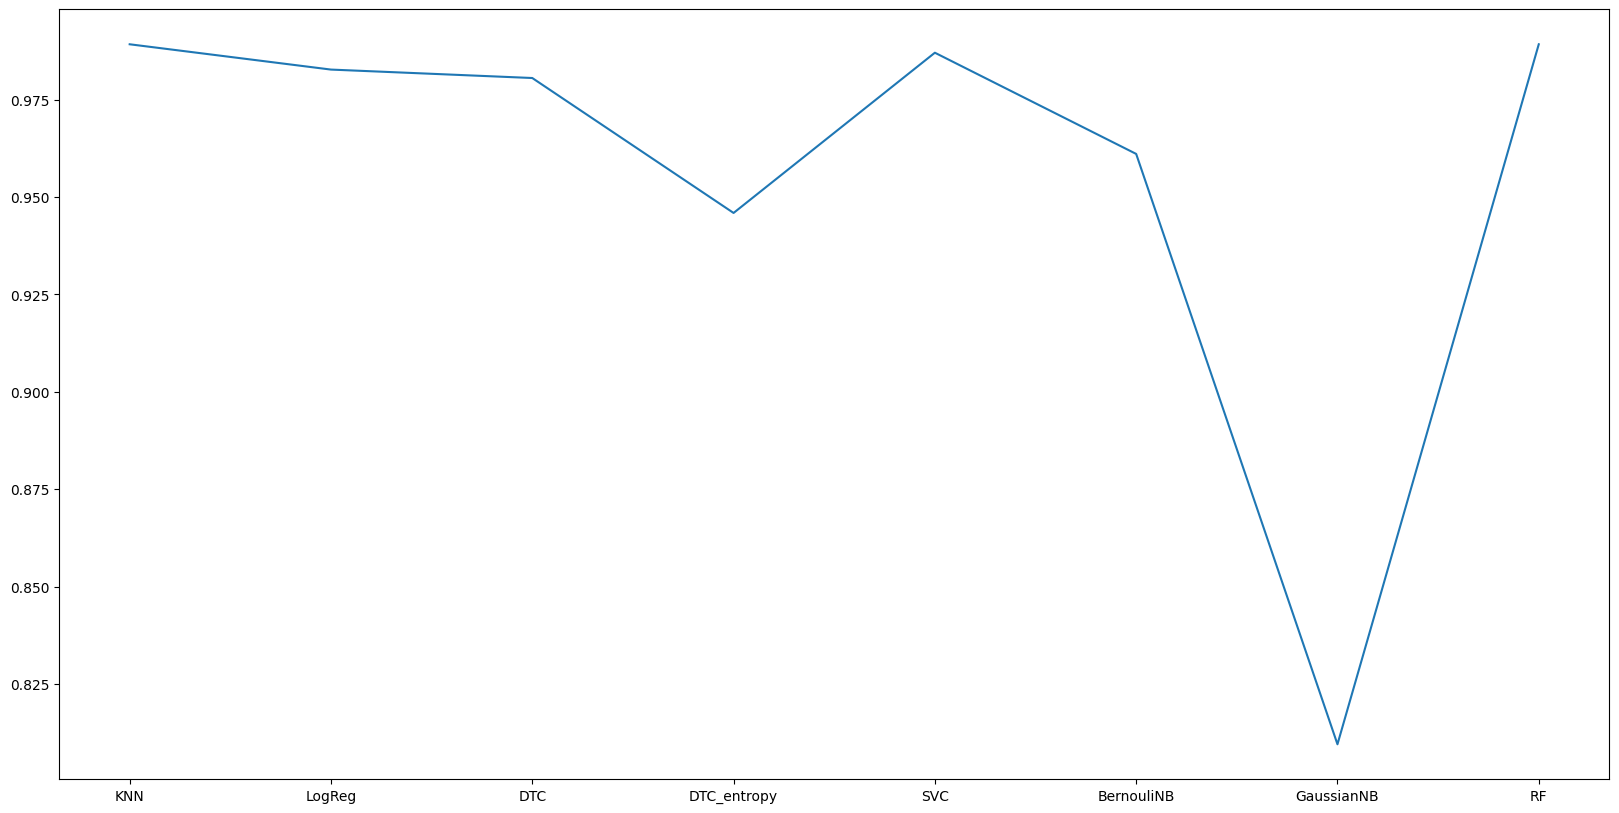

In [88]:
ax = plt.subplots(figsize=(20,10))
ax = plt.plot(model_name , model_acc)
ax

## more detailed search in Random Forest Hyper parameters

In [89]:
#Number of trees
n_estimator = [int(x) for x in np.linspace(start = 10 ,stop = 80, num = 10)]
#Number of features to consider at every split
max_features = ['log2' , 'sqrt']
#Maximum samples required
max_depth =  [int(x) for x in np.linspace(start = 10 ,stop = 100, num = 5)]
#Minimum samples required to split the node
min_samples_split = [int(x) for x in np.linspace(start = 5 ,stop = 60, num = 5)]
#Minimum number of samples required at each leaf
min_samples_leaf = [int(x) for x in np.linspace(start = 1 ,stop = 10, num = 2)]
#Method of selecting samples for training each tree
bootstrap = [True , False]

In [90]:
#creating the param grid
param_grid = {
    'n_estimators': n_estimator,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap':bootstrap
}


In [91]:
rf_Model2 = RandomForestClassifier()

trainer = ModelTrainer(rf_Model2,param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("RF_tuned")

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'bootstrap': False, 'max_depth': 55, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 56}


c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross Validation Scores: [0.98561151 0.97111913 0.99277978 0.98194946 0.98916968]
Mean Cross Validation Score: 0.9841259122665766
Training Set Scores in Each Fold:
[0.98863613 0.98809494 0.98989935 ... 0.96410546 0.96374527 0.96194054]
validation Set Score: 0.9891774891774892
Confusion Matrix:
[[437   0   0   0   0   0   0]
 [  1   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  2   0   0   0   9   0   0]
 [  0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   1]]
F1 Score: 0.9868162589119309
Accuracy Score: 0.9891774891774892
Classification Report:
              precision    recall  f1-score   support

     Android       0.99      1.00      1.00       437
        EMUI       0.00      0.00      0.00         2
   HarmonyOS       0.00      0.00      0.00         0
      Others       0.00      0.00      0.00         1
     Windows       1.00      0.82      0.90        11
         iOS       1.00      1.00      1.00        10
      iPadOS       1.

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

## Choosing the best model to fit on the test data

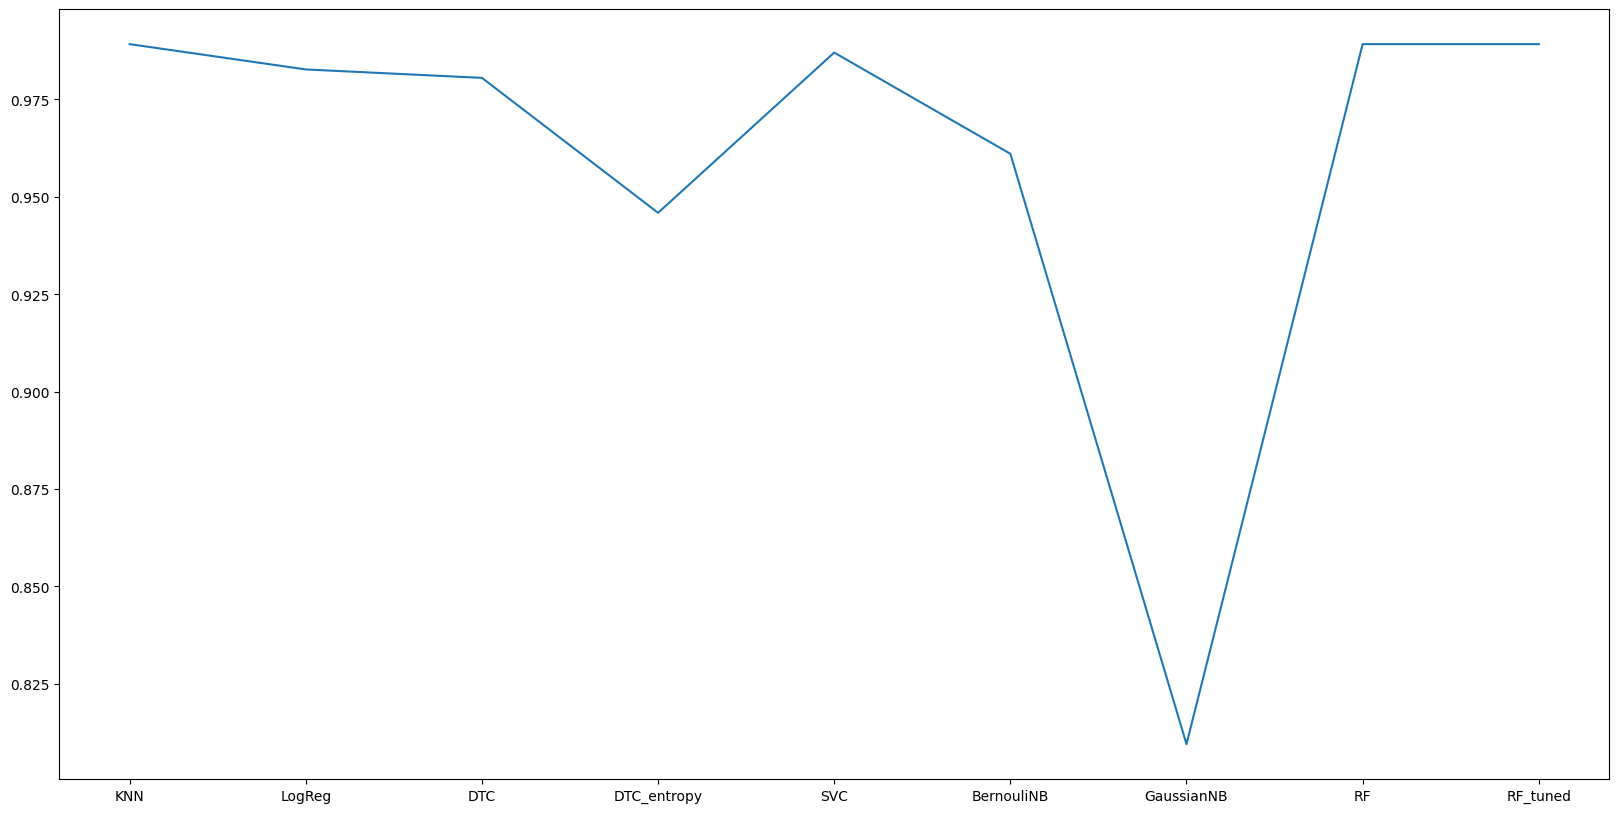

In [92]:
ax = plt.subplots(figsize=(20,10))
ax = plt.plot(model_name , model_acc)
ax

In [93]:
svc = SVC()

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

trainer = ModelTrainer(svc,param_grid)

acc = trainer.train(X_train, y_train, X_test, y_test)



c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Cross Validation Scores: [0.97482014 0.97833935 0.98916968 0.98555957 0.99277978]
Mean Cross Validation Score: 0.9841337038672311
Training Set Scores in Each Fold:
[0.98665253 0.97240253 0.95797251 0.95652945 0.98665253 0.97222219
 0.95869388 0.95797251 0.99152243 0.98755424 0.97799413 0.96933622
 0.99152243 0.98683287 0.97781378 0.96933622 0.99675318 0.99386754
 0.99134225 0.97077879 0.99675318 0.99404788 0.99116191 0.97113948]
validation Set Score: 0.9755351681957186
Confusion Matrix:
[[304   0   0   1   0]
 [  0   0   0   0   0]
 [  2   2   2   0   0]
 [  3   0   0   1   0]
 [  0   0   0   0  12]]
F1 Score: 0.9735561997164364
Accuracy Score: 0.9755351681957186
Classification Report:
              precision    recall  f1-score   support

     Android       0.98      1.00      0.99       305
        EMUI       0.00      0.00      0.00         0
   HarmonyOS       1.00      0.33      0.50         6
     Windows       0.50 

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics

## Dividing Battery Capacity

In [94]:
X['battery_capacity'].min()

50.0

In [95]:
X['battery_capacity'].max()

11560.0

In [96]:
X['battery_capacity'].mean()

3665.9245977011497

(array([  6., 471., 700., 457., 376.,  67.,  54.,  22.,  16.,   6.]),
 array([   50.,  1201.,  2352.,  3503.,  4654.,  5805.,  6956.,  8107.,
         9258., 10409., 11560.]),
 <BarContainer object of 10 artists>)

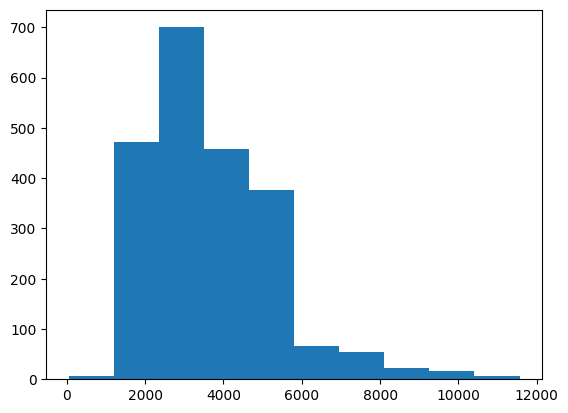

In [97]:
plt.hist(X['battery_capacity'])

In [98]:
def clustering(x):
    if  0<float(x)<3666:
        return 1
    elif 3665<=float(x)<5000:
        return 2
    elif 5000<=float(x)<12000: 
        return 3

In [99]:
X['battery_capacity'] = X['battery_capacity'].apply(clustering)

In [100]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [101]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
X_val= scaler.transform(X_val)

In [102]:
svc = SVC()

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

trainer = ModelTrainer(svc,param_grid)

acc = trainer.train(X_train, y_train, X_test, y_test)

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Cross Validation Scores: [0.97482014 0.98194946 0.98555957 0.98555957 0.98916968]
Mean Cross Validation Score: 0.9834116822065813
Training Set Scores in Each Fold:
[0.98538964 0.97222219 0.95941542 0.95743116 0.98538964 0.97204184
 0.95941542 0.95905457 0.99134209 0.9875544  0.97763344 0.96933622
 0.99134209 0.98701321 0.97763344 0.96933622 0.99657268 0.99422822
 0.99152259 0.97438646 0.99657268 0.99422822 0.99116191 0.97366509]
validation Set Score: 0.9724770642201835
Confusion Matrix:
[[303   0   1   1   0   0]
 [  0   0   0   0   0   0]
 [  2   1   3   0   0   0]
 [  3   0   0   1   0   0]
 [  0   0   0   0  11   1]
 [  0   0   0   0   0   0]]
F1 Score: 0.9722590919794704
Accuracy Score: 0.9724770642201835
Classification Report:
              precision    recall  f1-score   support

     Android       0.98      0.99      0.99       305
        EMUI       0.00      0.00      0.00         0
   HarmonyOS       0.75      0.5

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics

## EXTERA

In [112]:
df['battery_capacity'] = df['battery_capacity'].apply(clustering)

In [113]:
X=df.drop(['Unnamed: 0', 'name','Weight','OS',
           'Length', 'Width', 'Diameter', 
           'Display Type','ratio','WLAN', 
           'Colors', 'Sensors', 'Bluetooth', 
           'GPU','Chipset', 'Network', 'Internal',
           'Card slot','pixel','battery_capacity'],axis=1)
y = df['battery_capacity']
OS_name = pd.get_dummies(X['OS_name'],prefix='OS_name')
X = pd.concat([X,OS_name],axis=1).drop(['OS_name'],axis=1)
X

,2G,3G,4G,5G,Announced,Display Size,ppi,body ratio,Price,CPU,...,Status_Available,Status_Coming,Status_Discontinued,OS_name_Android,OS_name_EMUI,OS_name_HarmonyOS,OS_name_Others,OS_name_Windows,OS_name_iOS,OS_name_iPadOS
0,True,True,True,False,2022.0,5.50,293.0,74.0,100.0,4.0,...,True,False,False,True,False,False,False,False,False,False
1,True,True,True,False,2021.0,6.10,282.0,78.1,110.0,8.0,...,True,False,False,True,False,False,False,False,False,False
2,True,True,True,False,2021.0,5.00,215.0,71.4,60.0,4.0,...,True,False,False,True,False,False,False,False,False,False
3,True,True,True,False,2021.0,6.52,269.0,82.0,330.0,8.0,...,True,False,False,True,False,False,False,False,False,False
4,True,True,True,False,2021.0,6.52,269.0,82.0,130.0,8.0,...,True,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,True,True,False,False,2011.0,4.20,222.0,60.9,200.0,2.0,...,False,False,True,True,False,False,False,False,False,False
2626,True,True,False,False,2011.0,10.10,149.0,65.7,370.0,2.0,...,False,False,True,True,False,False,False,False,False,False
2627,True,True,True,False,2011.0,10.10,149.0,65.7,290.0,2.0,...,False,False,True,True,False,False,False,False,False,False
2628,True,True,False,False,2011.0,8.90,170.0,63.0,290.0,2.0,...,False,False,True,True,False,False,False,False,False,False


In [114]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [115]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
X_val= scaler.transform(X_val)

In [116]:
model_name = []
model_acc = []

In [117]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7,10,20], 'weights': ['uniform', 'distance']}

trainer = ModelTrainer(knn, param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_name.append("KNN")
model_acc.append(acc)

Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Cross Validation Scores: [0.76978417 0.77256318 0.7833935  0.77256318 0.79783394]
Mean Cross Validation Score: 0.7792275926551178
Training Set Scores in Each Fold:
[0.8744584  1.         0.83748051 1.         0.81601811 1.
 0.79996305 1.         0.75504976 1.        ]
validation Set Score: 0.7922077922077922
Confusion Matrix:
[[248  16   6]
 [ 31  42  11]
 [  4  28  76]]
F1 Score: 0.7907954676640764
Accuracy Score: 0.7922077922077922
Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.92      0.90       270
           2       0.49      0.50      0.49        84
           3       0.82      0.70      0.76       108

    accuracy                           0.79       462
   macro avg       0.73      0.71      0.72       462
weighted avg       0.79      0.79      0.79       462



In [118]:
LogReg = LogisticRegression()

trainer = ModelTrainer(LogReg)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("LogReg")

validation Set Score: 0.8268398268398268
Confusion Matrix:
[[255  11   4]
 [ 27  46  11]
 [  2  25  81]]
F1 Score: 0.8244045009275394
Accuracy Score: 0.8268398268398268
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.94      0.92       270
           2       0.56      0.55      0.55        84
           3       0.84      0.75      0.79       108

    accuracy                           0.83       462
   macro avg       0.77      0.75      0.76       462
weighted avg       0.82      0.83      0.82       462



In [119]:
tree_clf = DecisionTreeClassifier()
param_grid = {'max_depth': [None, 3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

trainer = ModelTrainer(tree_clf,param_grid)


acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("DTC")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Cross Validation Scores: [0.85251799 0.81227437 0.81949458 0.82310469 0.81949458]
Mean Cross Validation Score: 0.8253772433316884
Training Set Scores in Each Fold:
[1.         0.97240318 0.94137708 0.95508703 0.94913442 0.92676689
 0.91720628 0.91720628 0.91413981 0.80933924 0.80933924 0.80933924
 0.80861771 0.80861771 0.80861771 0.80861771 0.80861771 0.80861771
 0.85010694 0.84884454 0.84776216 0.84667994 0.84667994 0.8459584
 0.84379364 0.84379364 0.84379364 0.89935204 0.89466248 0.88888988
 0.88889021 0.88870954 0.88474119 0.88239527 0.88239527 0.88077219]
validation Set Score: 0.8376623376623377
Confusion Matrix:
[[246  16   8]
 [ 22  55   7]
 [  6  16  86]]
F1 Score: 0.837893175248931
Accuracy Score: 0.8376623376623377
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.91      0.90       270
           2       0.63      0.65      0.64       

In [120]:
svc = SVC()

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

trainer = ModelTrainer(svc,param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("SVC")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Cross Validation Scores: [0.85611511 0.86642599 0.81588448 0.83393502 0.84837545]
Mean Cross Validation Score: 0.8441472093083655
Training Set Scores in Each Fold:
[0.84397447 0.62968866 0.76010277 0.72276256 0.84397447 0.62608165
 0.75974208 0.72095914 0.85894356 0.77886199 0.86435645 0.78769568
 0.85894356 0.77038539 0.86345457 0.78913859 0.8621912  0.90620343
 0.92189666 0.72817349 0.8621912  0.90530172 0.92117529 0.72564479]
validation Set Score: 0.8506493506493507
Confusion Matrix:
[[252  15   3]
 [ 19  56   9]
 [  2  21  85]]
F1 Score: 0.8519983893310202
Accuracy Score: 0.8506493506493507
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.93      0.93       270
           2       0.61      0.67      0.64        84
           3       0.88      0.79      0.83       108

    accuracy                           0.85       462
   macro avg       0.80      0.80      0.

In [121]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

trainer = ModelTrainer(rf,param_grid)
acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("RF")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross Validation Scores: [0.9028777  0.86281588 0.87725632 0.85559567 0.8700361 ]
Mean Cross Validation Score: 0.873716333792172
Training Set Scores in Each Fold:
[1.         1.         1.         0.98124095 0.97997773 0.98051941
 0.9514792  0.95310294 0.95165889 0.95869388 0.96031697 0.96085799
 0.95490604 0.95382382 0.95562773 0.93596631 0.93470424 0.93632749
 0.91792879 0.91522317 0.91738825 0.91648589 0.91666705 0.9190115
 0.91161534 0.9137814  0.91360057 0.86417757 0.86886762 0.86940734
 0.86309454 0.87031003 0.86399658 0.86165066 0.86417838 0.86020987
 0.86020971 0.86471811 0.86507961 0.86075008 0.86291501 0.86724356
 0.86111126 0.86057023 0.86561917 0.86057104 0.86291582 0.86147129
 0.86002757 0.85858678 0.86598034 0.85822447 0.85948736 0.86273499
 0.96536819 0.9653677  0.96771248 0.94967512 0.95129821 0.95093817
 0.93145693 0.93344152 0.93181713 0.94209927 0.93975384 0.94173

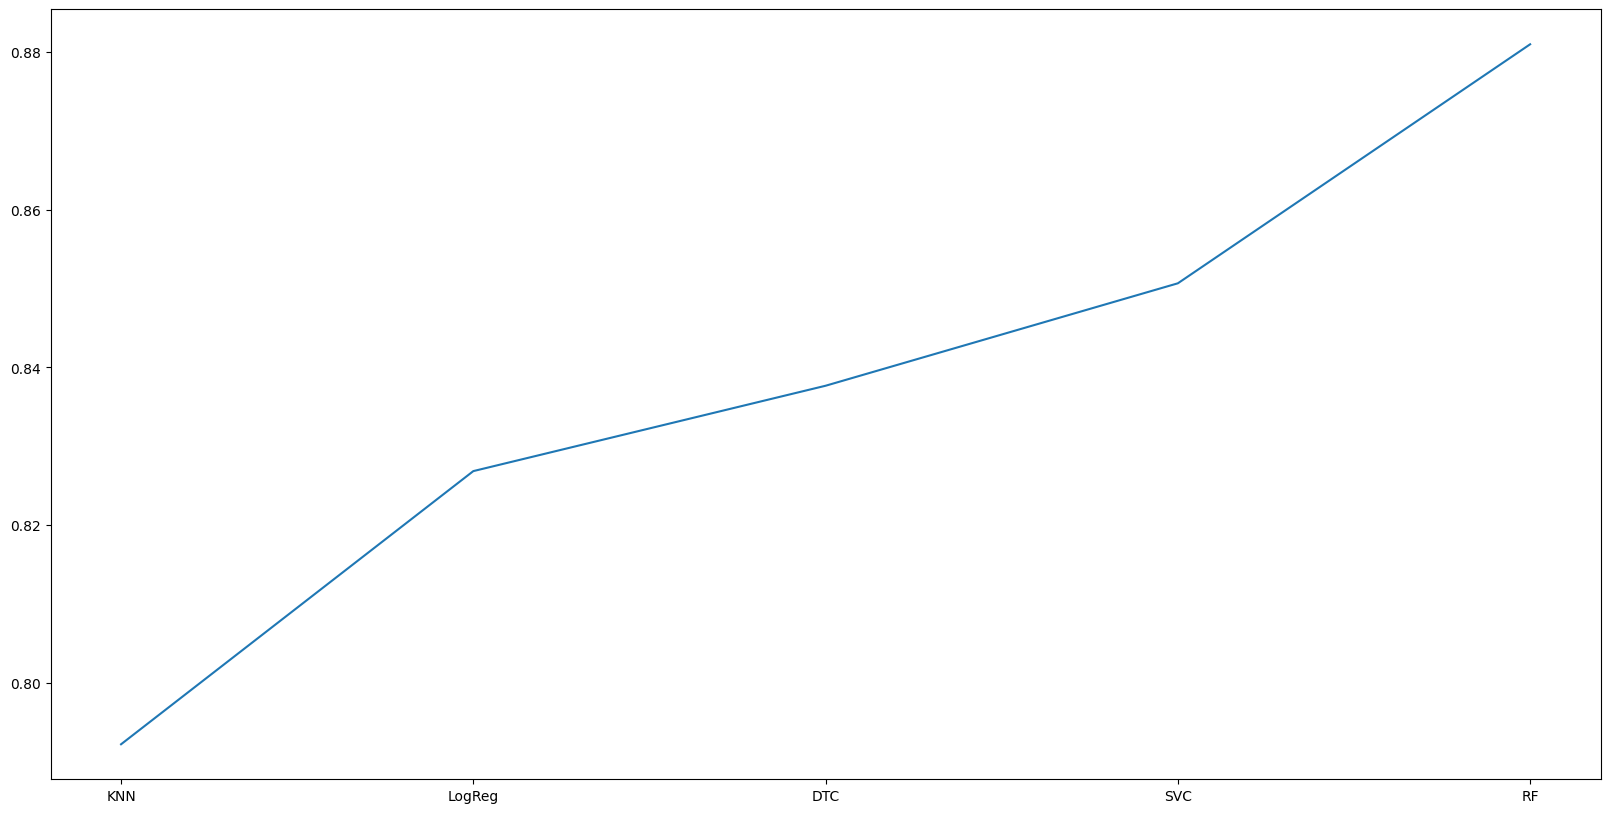

In [122]:
ax = plt.subplots(figsize=(20,10))
ax = plt.plot(model_name , model_acc)
ax

In [123]:
#Number of trees
n_estimator = [int(x) for x in np.linspace(start = 10 ,stop = 80, num = 10)]
#Number of features to consider at every split
max_features = ['log2' , 'sqrt']
#Maximum samples required
max_depth =  [int(x) for x in np.linspace(start = 10 ,stop = 100, num = 5)]
#Minimum samples required to split the node
min_samples_split = [int(x) for x in np.linspace(start = 5 ,stop = 60, num = 5)]
#Minimum number of samples required at each leaf
min_samples_leaf = [int(x) for x in np.linspace(start = 1 ,stop = 10, num = 2)]
#Method of selecting samples for training each tree
bootstrap = [True , False]

In [124]:
#creating the param grid
param_grid = {
    'n_estimators': n_estimator,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap':bootstrap
}

In [125]:
rf_Model2 = RandomForestClassifier()

trainer = ModelTrainer(rf_Model2,param_grid)

acc = trainer.train(X_train, y_train, X_val, y_val)

model_acc.append(acc)
model_name.append("RF_tuned")

Best Parameters: {'bootstrap': False, 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 48}
Cross Validation Scores: [0.91366906 0.87364621 0.85559567 0.8700361  0.88447653]
Mean Cross Validation Score: 0.8794847154767161
Training Set Scores in Each Fold:
[0.92929299 0.9341637  0.93975481 ... 0.8661602  0.87481697 0.87175212]
validation Set Score: 0.8852813852813853
Confusion Matrix:
[[258   9   3]
 [ 19  59   6]
 [  4  12  92]]
F1 Score: 0.8839171621092016
Accuracy Score: 0.8852813852813853
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       270
           2       0.74      0.70      0.72        84
           3       0.91      0.85      0.88       108

    accuracy                           0.89       462
   macro avg       0.86      0.84      0.85       462
weighted avg       0.88      0.89      0.88       462



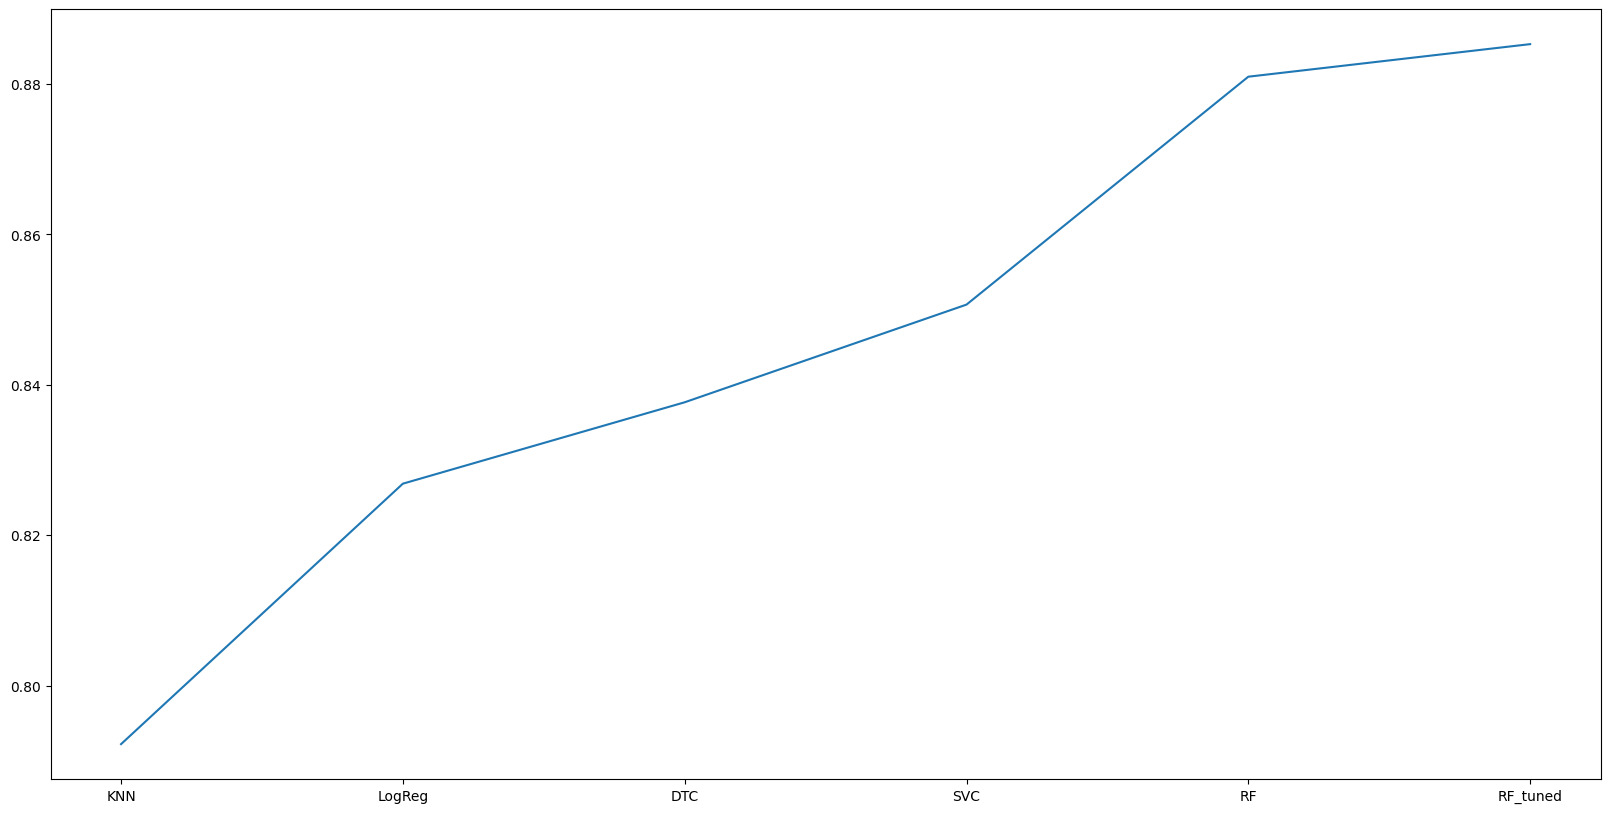

In [126]:
ax = plt.subplots(figsize=(20,10))
ax = plt.plot(model_name , model_acc)
ax

In [127]:
rf_Model2 = RandomForestClassifier()

trainer = ModelTrainer(rf_Model2,param_grid)

acc = trainer.train(X_train, y_train, X_test, y_test)

model_acc.append(acc)
model_name.append("RF_tuned")

Best Parameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 72}
Cross Validation Scores: [0.89568345 0.8700361  0.86642599 0.8700361  0.88086643]
Mean Cross Validation Score: 0.8766096148352076
Training Set Scores in Each Fold:
[0.93109576 0.93560612 0.94011436 ... 0.86489878 0.86886648 0.87193198]
validation Set Score: 0.8715596330275229
Confusion Matrix:
[[172   5   0]
 [ 13  49   9]
 [  3  12  64]]
F1 Score: 0.8689023709893618
Accuracy Score: 0.8715596330275229
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.97      0.94       177
           2       0.74      0.69      0.72        71
           3       0.88      0.81      0.84        79

    accuracy                           0.87       327
   macro avg       0.84      0.82      0.83       327
weighted avg       0.87      0.87      0.87       327



NN

In [103]:
class Classification_nn(nn.Module):
    def __init__(self , in_features , hidden_features , y):
        super().__init__()
        self.flatten = nn.Flatten()
        self.block_1 = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.Sigmoid(),
            nn.Linear(hidden_features , 512),
            nn.Sigmoid(),
            nn.Linear(512 , 1))
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        return x.squeeze().float()

NameError: name 'nn' is not defined

In [ ]:
c_model = Classification_nn(7 , 256 , len(list(df1['OS'].unique())))
print(c_model)

Classification_nn(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (block_1): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [ ]:
criterion = torch.nn.BCELoss()
optimizer_sgd = optim.Adam(c_model.parameters() , lr= 0.01)

In [ ]:
norm = MaxAbsScaler()
X = norm.fit_transform(X)
X

array([[0.        , 0.4       , 0.05      , ..., 0.87272727, 0.44008264,
        0.25951557],
       [0.        , 0.8       , 0.055     , ..., 0.36363636, 0.97107438,
        0.25951557],
       [0.        , 0.4       , 0.03      , ..., 0.86818182, 0.3946281 ,
        0.17301038],
       ...,
       [0.76923077, 0.2       , 0.145     , ..., 0.96818182, 0.56818182,
        0.58823529],
       [0.76923077, 0.2       , 0.145     , ..., 0.96818182, 0.56818182,
        0.51903114],
       [0.76923077, 0.2       , 0.085     , ..., 0.44090909, 0.07644628,
        0.14273356]])

In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []


for epoch in range(num_epochs):
    c_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in zip(torch.Tensor(X_train) , torch.Tensor(y_train)):
        #print('Weights before update:', binary_mlp_classifier.block_1[1].weight)
        # Zero the gradients
        optimizer_sgd.zero_grad()

        outputs = c_model(inputs)
        # Compute the loss (use your implemented loss function)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        print(loss)
        torch.nn.utils.clip_grad_norm_(c_model.parameters(), max_norm=1)
        optimizer_sgd.step()
        # Calculate training accuracy
        predicted = (outputs >= 0.5).float()
        correct_predictions += (predicted == labels.view(-1, 1)).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

   
    train_accuracy = correct_predictions / total_samples
    avg_loss = running_loss / len(X_train)
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {train_accuracy:.4f} - Train Loss: {avg_loss:.4f}")

RuntimeError: all elements of target should be between 0 and 1